<a href="https://colab.research.google.com/github/noobmaster-ru/numerical_methods_6sem/blob/main/numerical_methods_task_3_kozlov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.hd

19 мая 13:12 - версия на 5 , но без допзадания

# Вычисление

## Импорт библиотек

In [918]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
import math
import matplotlib.ticker as ticker
from scipy.interpolate import interp1d
import time
from itertools import product
import inspect

## Задание констант c1, c2, c3, g0, g1, beta0, beta1

In [919]:
'''
Параметры сетки(чем больше,тем сильнее сгущение):
   •	c1 > 0: сгущение к левому краю отрезка
   •	c3 < 0: сгущение к правому краю
   •	c2 = 0: равномерно
'''

# (+) <----
# (-) ---->
c1 = -2.5
c_symmetric = 2.0
c3 = 2.0


# N - количество узлов на каждом отрезке(то есть всего будет 4*N узлов)
N = 30

# Эпсилон окрестность для приближенного графика решения
eps = 0.25


g0 = 0.0
g1 = 1.0
beta_0 = 1.0
beta_1 = 1.0

## Генерация равномерной сетки

In [920]:
# генерация равномерной сетки - чтобы узлы сетки в разрыва попали на до //6
def generate_equal_grid(N):
    # нужно чтобы на 6 делилась сетка
    N = math.ceil(N / 6) * 6
    x = np.linspace(0, np.pi, N + 1)
    return x

## Генерация неравномерной сетки

In [921]:
def phi(t, alpha, beta, c):
  """
  Монотонная трансформация t ∈ [0,1] в [alpha, beta] с экспоненциальным сгущением
  """
  if c == 0:
      return alpha + (beta - alpha) * t  # равномерно
  return alpha + (beta - alpha) * (np.exp(c * t) - 1) / (np.exp(c) - 1)

def phi_symmetric(t, alpha, beta, c):
    """
    Симметричное сгущение точек t ∈ [0,1] к концам отрезка [alpha, beta] ([π/2, 2π/3])
    """
    if c == 0:
        return alpha + (beta - alpha) * t  # равномерно


    s = 0.5 * (1 - np.tanh(c * (0.5 - t)) / np.tanh(c / 2))
    return alpha + (beta - alpha) * s

def generate_segment(alpha, beta, N, c, symmetric = False):
  """
  Генерация сетки на отрезке [alpha, beta] с N интервалами, используя phi
  """
  t = np.linspace(0, 1, N + 1)
  if symmetric:
    return phi_symmetric(t, alpha, beta, c)
  else:
    return phi(t, alpha, beta, c)

In [922]:
# Создание неравномерной сетки
def generate_grid(N):
    """
    Генерация неравномерной сетки на [0, pi], разбитой на 3 части:
    [0, pi/2], [pi/2, 2pi/3], [2pi/3, pi]
    Параметры:
      •	c1 > 0: сгущение к левому краю отрезка
      •	c3 < 0: сгущение к правому краю
      •	c2 = 0: равномерно
    """
    x0 = 0
    x1 = np.pi / 2
    x2 = 2 * np.pi / 3
    x3 = np.pi


    grid1 = generate_segment(x0, x1, N, c1)[:-1]  # [0, pi/2)
    grid2 = generate_segment(x1, x2, N, c_symmetric, symmetric = True)[:-1]  # [pi/2 ,2*np.pi/3)
    grid3 = generate_segment(x2, x3, N, c3) # [2pi/3 ,pi]

    return np.concatenate([grid1, grid2, grid3])

In [923]:
x = generate_grid(N)

## Задание p, q ,f

In [924]:
# Задание коэффициентов - РАЗРЫВНЫЕ из варианта задания
def p(x_i):
  if x_i <= (np.pi / 3):
      return (x_i - np.pi / 2) ** 2
  elif x_i < (2 * np.pi / 3):
      return x_i ** 2
  else:
      return 0.1 + (x_i - np.pi) ** 2

def q(x_i):
  return 1.0

def f(x_i):
  if x_i < (np.pi / 2.0):
    return np.sin(x_i)
  else:
    return 1.0 + np.sin(x_i)

In [925]:
# Парсим функции для удобного вывода
def parse_function(func):
    source = inspect.getsource(func)
    lines = [line.strip() for line in source.split('\n')]

    def_line = lines[0]
    func_name = def_line.split('def ')[1].split('(')[0]
    args = def_line.split('(')[1].split(')')[0].replace('x_i','x')

    expr = None
    for line in reversed(lines):
        if line.startswith('return ') and not line.startswith('#') and not line.startswith('    #'):
            expr = line.split('return ')[1].strip()
            break
    if expr is None:
        return f"{func_name}({args}) = <no return statement>"
    expr = expr.replace('np.', '').replace('.0', '').replace('**', '^').replace('x_i','x')
    return f"{func_name}({args}) = {expr}"

## Построение графиков

In [926]:
def plot_grid(x):
    plt.figure(figsize=(16, 2.0))
    plt.eventplot(x, orientation='horizontal', colors='blue', linewidth=1.2)

    # Вертикальные линии разрыва
    plt.axvline(np.pi/2, color='red', linestyle='--',dashes=(1, 1), linewidth=1.2, label=r'$\frac{\pi}{2}$')
    plt.axvline(2*np.pi/3, color='green', linestyle='--',dashes=(1, 1), linewidth=1.2, label=r'$\frac{2\pi}{3}$')

    # Настройка xticks
    tick_positions = [0, np.pi/2, 2*np.pi/3, np.pi]
    tick_labels = [r'$0$',r'$\frac{\pi}{2}$', r'$\frac{2\pi}{3}$', r'$\pi$']
    plt.xticks(tick_positions, tick_labels, fontsize=15)

    # Остальные настройки
    plt.title("Неравномерная сетка с экспоненциальным сгущением с узлами в точках разрыва", fontsize=20)
    plt.yticks([])
    plt.xlabel("Ось Ox",  fontweight='bold', fontsize=15)
    plt.grid(True, axis='x', linestyle=':', alpha=0.9)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.35)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=15)
    plt.tight_layout()
    plt.show()
    print("\n")

In [927]:
def plot_solution(x,u,u_true, equal_grid):
    fig = plt.figure(figsize=(16, 8))
    plt.plot(x, u, label=f"u(x), N = {len(x)} узлов", color="blue", linewidth=4)
    plt.plot(x, u_true, linestyle='--', label="Истинное решение scipy.linalg.solve",color="red",linewidth=4)

    # Добавим вертикальные линии в точках разрыва
    plt.axvline(np.pi/2, color='navy', linestyle='--', linewidth=1.0)
    plt.axvline(2*np.pi/3, color='green', linestyle='--', linewidth=1.0)

    # Добавим маркеры в этих точках, если они присутствуют в сетке x - eps
    for xi, color in [(np.pi/2, 'navy'), (2*np.pi/3, 'green'), (x[0], 'black'),(x[-1], 'black')]:
        idx = np.argmin(np.abs(x - xi))
        plt.plot(x[idx], u[idx], 'o', color=color, markersize=7, label=fr'$u(\frac{{{int(round(xi/np.pi*3))}\pi}}{{3}})$')

    # Оформление осей
    plt.xlabel("Ось x", labelpad=10, fontsize=20, fontweight='bold')
    plt.ylabel("u(x)", rotation=0, labelpad=10, fontsize=20, fontweight='bold')
    if equal_grid:
      plt.title("Численное решение краевой задачи(равномерная сетка)", fontsize=20)
      for i in range(len(x)):
        plt.axvline(x[i], color='black', linestyle='--', linewidth=0.5)
    else:
      plt.title("Численное решение краевой задачи(неравномерная сетка)", fontsize=20)

    # Подписи оси X
    tick_positions = [0, np.pi/2, 2*np.pi/3, np.pi]
    tick_labels = [r'$0$', r'$\frac{\pi}{2}$', r'$\frac{2\pi}{3}$', r'$\pi$']
    plt.xticks(tick_positions, tick_labels, fontsize=15)

    # Сетка
    plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)

    # Легенда
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.show()
    print("\n")

In [928]:
def zoom_around_discontinuity(x, u, x0, eps, point):
    """
    Визуализация решения на участке [x0 - eps, x0 + eps]
    """

    # Подсчёт количества узлов в подотрезке
    x_left = x0 - eps
    x_right = x0 + eps
    mask = (x >= x_left) & (x <= x_right)
    num_nodes_in_segment = np.sum(mask)
    mask = (x >= x0 - eps) & (x <= x0 + eps)
    x_zoom = x[mask]
    u_zoom = u[mask]
    plt.figure(figsize=(10, 6))
    plt.plot(x_zoom, u_zoom, '-',color='blue', linewidth=2, label=f"u(x), N = {num_nodes_in_segment} узлов")
    if point =="pi/2":
      label = r'Узлы в $[\frac{\pi}{2} - \varepsilon, \frac{\pi}{2} + \varepsilon]$, ' + fr'$\varepsilon = {eps}$'
      plt.plot(x_zoom, u_zoom, 'o', color='black', markersize=6, label=label,alpha=1.0)

      # Вертикальная линия в точке разрыва
      plt.axvline(x0, color='red', linestyle='--', linewidth=1.2, label=r'$x = \frac{\pi}{2}$')
      plt.title(r"Приближение к точке разрыва $x = \frac{\pi}{2}$", fontsize=15)
      plt.xlabel("Ось x", fontweight='bold', fontsize=15)
      plt.ylabel("u(x)",rotation=0, fontweight='bold', fontsize=15)

      # Подписи оси X
      tick_positions = [x_left,x0, x_right]
      tick_labels = [r'$\frac{\pi}{2}-\varepsilon$',r'$\frac{\pi}{2}$',r'$\frac{\pi}{2}+\varepsilon$']
      plt.xticks(tick_positions, tick_labels, fontsize=15)
      # Сетка
      plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
      plt.minorticks_on()
      plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)
      plt.legend()
      plt.tight_layout()
      plt.show()
      print("\n")
    else:
      label = r'Узлы в $[\frac{2\pi}{3} - \varepsilon, \frac{2\pi}{3} + \varepsilon]$, ' + fr'$\varepsilon = {eps}$'
      plt.plot(x_zoom, u_zoom, 'o', color='black', markersize=6, label=label,alpha=1.0)

      # Вертикальная линия в точке разрыва
      plt.axvline(x0, color='green', linestyle='--', linewidth=1.2, label=r'$x = \frac{2\pi}{3}$')
      plt.title(r"Приближение к точке разрыва $x = \frac{2\pi}{3}$", fontsize=15)
      plt.xlabel("Ось x", fontweight='bold', fontsize=15)
      plt.ylabel("u(x)",rotation=0, fontweight='bold', fontsize=15)

      # Подписи оси X
      tick_positions = [x_left,x0, x_right]
      tick_labels = [r'$\frac{2\pi}{3}-\varepsilon$',r'$\frac{2\pi}{3}$',r'$\frac{2\pi}{3}+\varepsilon$']
      plt.xticks(tick_positions, tick_labels, fontsize=15)

      # Сетка
      plt.grid(True, color='gray', which='both', linestyle='--', linewidth=0.6, alpha=0.95)
      plt.minorticks_on()
      plt.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)
      plt.legend()
      plt.tight_layout()
      plt.show()
      print("\n")

## Схема

In [929]:
def build_matrix_and_rhs(x):
    N = len(x) - 1

    A = np.zeros((N+1, N+1))
    b = np.zeros(N+1)

    # здесь всё ок
    # Левое граничное условие (второй порядок должен быть)
    A[0, 0] = 1
    A[0, 1] = 0.0
    b[0] = g0

    # здесь всё ок
    # Внутренние узлы (второй порядок второй порядок должен быть)
    for i in range(1, N):
        h_i_minus_1 = x[i] - x[i-1]
        h_i = x[i+1] - x[i]
        h_i_hatch = (h_i_minus_1 + h_i)/2
        x_i_minus_1_2 = (x[i] + x[i-1])/2
        x_i_plus_1_2 = (x[i+1] + x[i])/2

        p_i_minus_1_del_2 = p((x[i] + x[i-1]) / 2.0)
        p_i_plus_1_del_2 = p((x[i+1] + x[i]) / 2.0)

        # eps = 1e-10
        # if abs(x[i] - np.pi / 2) < eps or abs(x[i] - 2 * np.pi / 3) < eps:
        if (np.isclose(x[i], np.pi/2, atol=1e-10) or np.isclose(x[i], 2*np.pi/3, atol=1e-10)):

          A[i, i-1] = - p(x_i_minus_1_2)/(h_i_hatch*h_i_minus_1)
          A[i, i] = p(x_i_plus_1_2)/(h_i_hatch*h_i) + p(x_i_minus_1_2)/(h_i_hatch*h_i_minus_1) + (q(x_i_minus_1_2)+q(x_i_plus_1_2))/2
          A[i, i+1] = -p(x_i_plus_1_2)/(h_i_hatch*h_i)
          b[i] = (f(x_i_minus_1_2) + f(x_i_plus_1_2))/2

        else:
          A[i, i-1] = -p_i_minus_1_del_2 / h_i_minus_1
          A[i, i] = (p_i_minus_1_del_2 / h_i_minus_1) + (p_i_plus_1_del_2 / h_i) + (q(x[i]) * (h_i_minus_1 + h_i)) / 2.0
          A[i, i+1] = -p_i_plus_1_del_2 / h_i
          b[i] = f(x[i]) * (h_i_minus_1 + h_i) / 2.0


    # вроде заменил
    # Правое граничное условие ( второй порядок должен быть)
    h = x[-1] - x[-2]

    p_N_minus_1_del_2 = p((x[-1] + x[-2])/2)
    p_N_minus_1 = p(x[-2])
    q_N = q(x[-1])
    f_N = f(x[-1])
    p_L = p(np.pi)
    A[N, N-1] = - (p_N_minus_1_del_2 / h)
    A[N, N] = (p_N_minus_1_del_2 / h)  + (h / 2)*q_N
    b[N] = f_N * (h / 2) + g1


    return A, b

## Решения СЛАУ - прогонка

In [930]:
def progonka(A, b):
    n = len(b)
    a = np.zeros(n) # нижняя диагональ
    c = np.zeros(n) # вержняя диагональ
    diag = np.zeros(n)


    for i in range(n):
        diag[i] = A[i, i]
        if i > 0:
            a[i] = A[i, i - 1]
        if i < n - 1:
            c[i] = A[i, i + 1]

    # Прямая прогонка
    alpha = np.zeros(n)
    beta = np.zeros(n)

    alpha[0] = -c[0] / diag[0]
    beta[0] = b[0] / diag[0]

    for i in range(1, n):
        denom = a[i] * alpha[i - 1] + diag[i]
        if i < n - 1:
            alpha[i] = -c[i] / denom
        beta[i] = (b[i] - a[i] * beta[i - 1]) / denom

    # Обратная прогонка
    x = np.zeros(n)
    x[-1] = beta[-1]
    for i in reversed(range(n - 1)):
        x[i] = alpha[i] * x[i + 1] + beta[i]

    return x


## main


In [931]:
# Основной расчет
A, b = build_matrix_and_rhs(x)
u = progonka(A,b)
u_true = solve(A, b)

## Графики

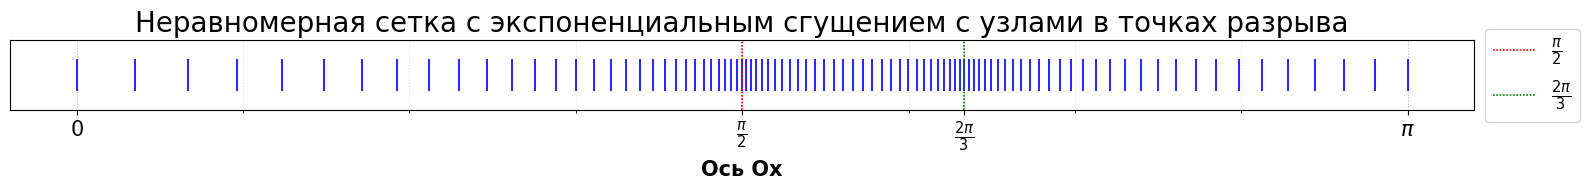

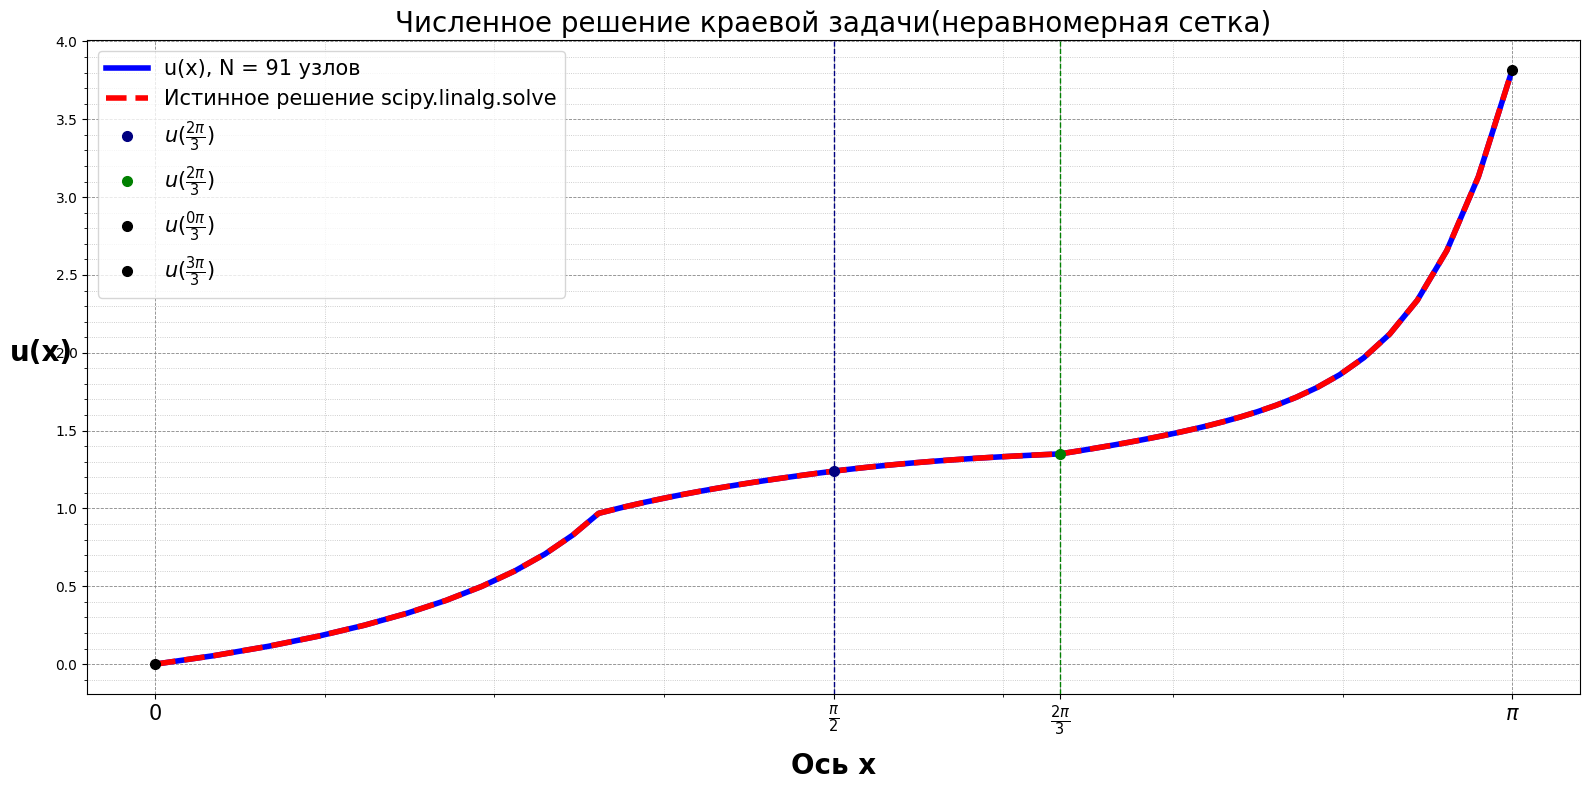

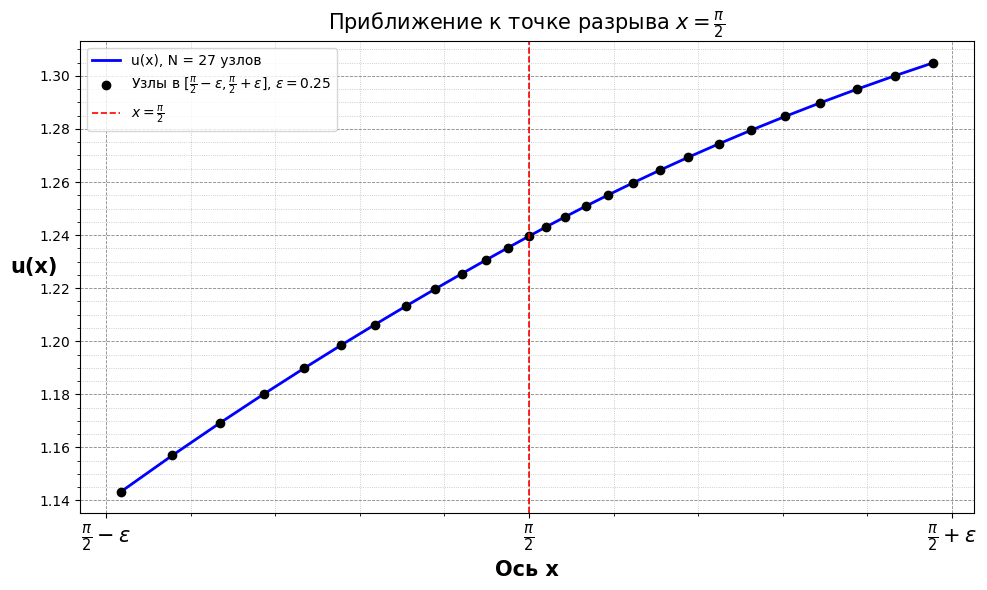

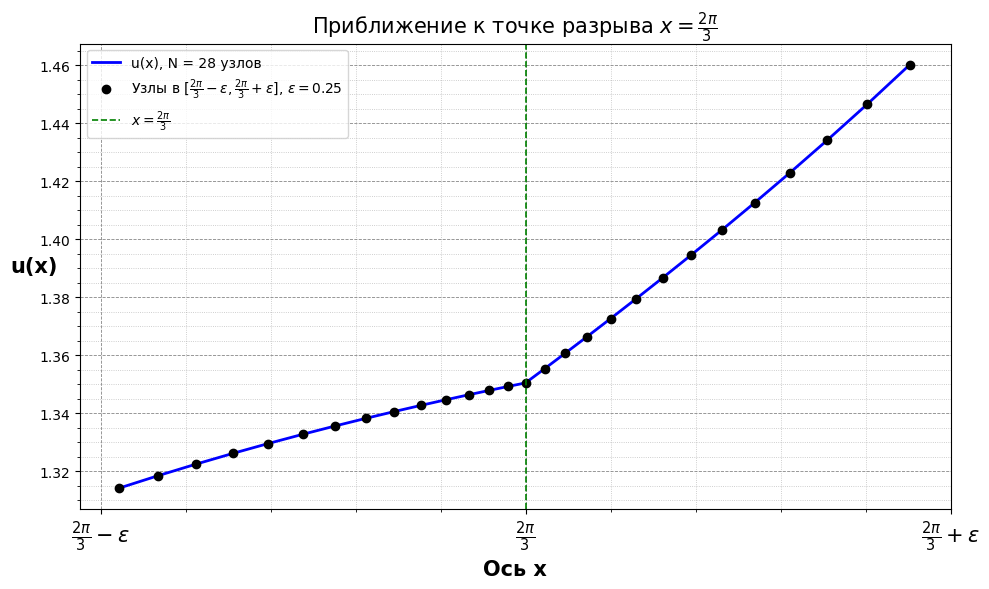

In [932]:
plot_grid(x) # Сетка
plot_solution(x,u,u_true,False) # Решение

# Приближение решения в окрестноти точек разрыва

zoom_around_discontinuity(x, u, np.pi/2, eps, "pi/2")
zoom_around_discontinuity(x, u, 2*np.pi/3, eps, "2pi/3")


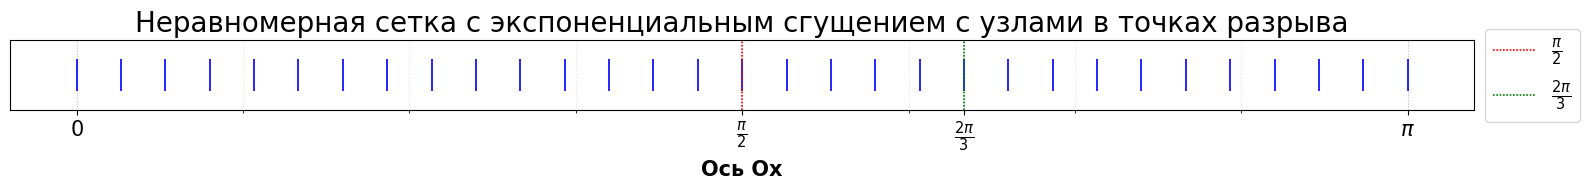

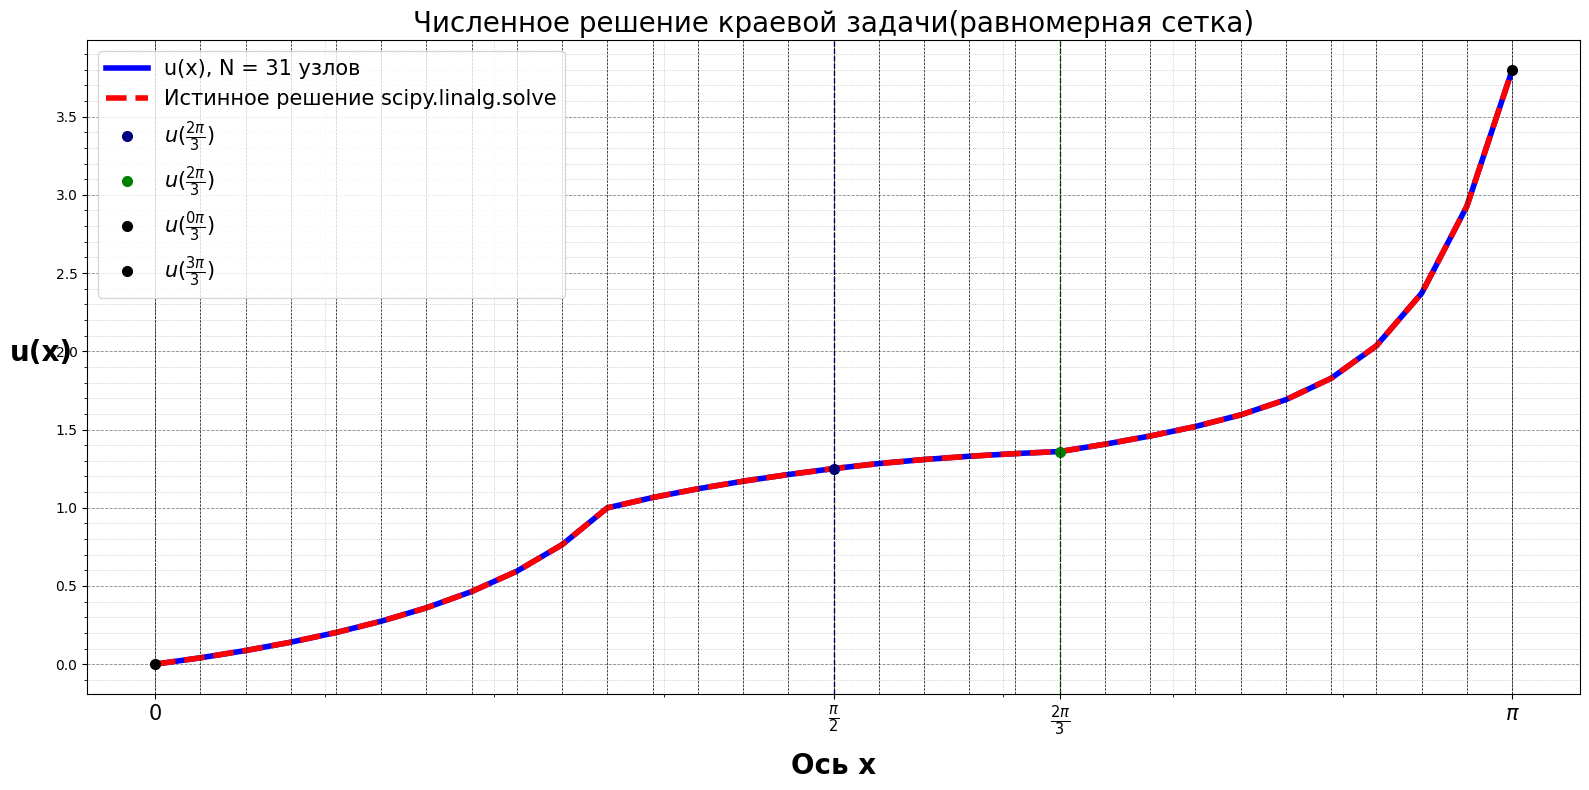

In [933]:
# Решение на равномерной сетке
x = generate_equal_grid(N)

# печать сетки
plot_grid(x)
A, b = build_matrix_and_rhs(x)
u = progonka(A,b)

# истинное решение
u_true = solve(A, b)

# печать решения
plot_solution(x,u,u_true,True)

# Оценка сходимости методом Рунге

In [934]:
# не знаю как у узлах сравнить , поэтому интерполяцию беру
def max_norm_error(x_coarse, u_coarse, x_fine, u_fine):
    u_coarse_interp = np.interp(x_fine, x_coarse, u_coarse)
    return np.max(np.abs(u_fine - u_coarse_interp))

In [935]:
# Численный расчет для метода Рунге
def numerical_solution(N, equal_grid):
  if equal_grid:
    x = generate_equal_grid(N)
  else:
    x = generate_grid(N)
  A, b = build_matrix_and_rhs(x)
  u = progonka(A,b)
  return x, u

In [936]:
# Метод Рунге для оценки порядка
def runge_convergence_v1(N_coarse, equal_grid ,r = 2):
  """
    • equal_grid = True - равномерная сетка
    • equal_grid = Fakse - неравномерная сетка
  """
  x_n, u_n = numerical_solution(N_coarse, equal_grid)
  x_2n, u_2n = numerical_solution(N_coarse * r, equal_grid)
  x_4n, u_4n = numerical_solution(N_coarse * r * r, equal_grid)

  norm_up = max_norm_error(x_n,u_n,x_2n,u_2n)
  norm_low = max_norm_error(x_2n,u_2n,x_4n,u_4n)
  rate = np.log2(norm_up / norm_low)

  return  rate

## РАЗРЫВНЫЕ p,q,f

In [937]:
Ns = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400,
      500, 600, 700, 800, 1000, 2000, 4000]

In [938]:
print(f"      Неравномерные сетки, разрывные коэфициенты\n")
print("Для каждого N правилом Рунге считается порядок\n")
print(f"c1 = {c1}, c2 = {c_symmetric}, c3 = {c3}\n")
for Number in Ns:
  rate = runge_convergence_v1(Number, equal_grid=False)
  print(f"N={Number}: порядок аппроксимации p ≈ {rate:.5f}")


      Неравномерные сетки, разрывные коэфициенты

Для каждого N правилом Рунге считается порядок

c1 = -2.5, c2 = 2.0, c3 = 2.0

N=10: порядок аппроксимации p ≈ 1.49625
N=20: порядок аппроксимации p ≈ 2.41738
N=30: порядок аппроксимации p ≈ 0.98345
N=40: порядок аппроксимации p ≈ -0.57631
N=50: порядок аппроксимации p ≈ 2.00372
N=60: порядок аппроксимации p ≈ 0.94544
N=70: порядок аппроксимации p ≈ 4.37555
N=80: порядок аппроксимации p ≈ 0.99884
N=90: порядок аппроксимации p ≈ 2.01120
N=100: порядок аппроксимации p ≈ -1.89858
N=200: порядок аппроксимации p ≈ 0.97866
N=300: порядок аппроксимации p ≈ 6.56393
N=400: порядок аппроксимации p ≈ 6.99163
N=500: порядок аппроксимации p ≈ 1.00638
N=600: порядок аппроксимации p ≈ -4.58021
N=700: порядок аппроксимации p ≈ 1.90520
N=800: порядок аппроксимации p ≈ 1.88860
N=1000: порядок аппроксимации p ≈ 0.98954
N=2000: порядок аппроксимации p ≈ 1.00743
N=4000: порядок аппроксимации p ≈ 9.09269


In [939]:
print(f"     Равномерные сетки , разрывные коэфициенты\n")
print("Для каждого N правилом Рунге считается порядок\n")

for Number in Ns:
  rate = runge_convergence_v1(Number,equal_grid=True)
  print(f"N={Number}: порядок аппроксимации p ≈ {rate:.5f}")

     Равномерные сетки , разрывные коэфициенты

Для каждого N правилом Рунге считается порядок

N=10: порядок аппроксимации p ≈ 2.10248
N=20: порядок аппроксимации p ≈ 1.44554
N=30: порядок аппроксимации p ≈ 1.99075
N=40: порядок аппроксимации p ≈ 2.03211
N=50: порядок аппроксимации p ≈ 1.77290
N=60: порядок аппроксимации p ≈ 1.99782
N=70: порядок аппроксимации p ≈ 2.01938
N=80: порядок аппроксимации p ≈ 1.85729
N=90: порядок аппроксимации p ≈ 1.99912
N=100: порядок аппроксимации p ≈ 2.01388
N=200: порядок аппроксимации p ≈ 1.94262
N=300: порядок аппроксимации p ≈ 1.99998
N=400: порядок аппроксимации p ≈ 2.00362
N=500: порядок аппроксимации p ≈ 1.97700
N=600: порядок аппроксимации p ≈ 2.00002
N=700: порядок аппроксимации p ≈ 2.00209
N=800: порядок аппроксимации p ≈ 1.98562
N=1000: порядок аппроксимации p ≈ 2.00148
N=2000: порядок аппроксимации p ≈ 1.99408
N=4000: порядок аппроксимации p ≈ 2.00256


## ГЛАДКИЕ p,q,f

In [940]:
# Задание коэффициентов - ГЛАДКИЕ
def p(x_i):
  return 0.2  + np.exp(x_i)**2

def q(x_i):
  return 1.0  + np.sin(x_i)*x_i**2

def f(x_i):
  return 0.5 + np.cos(x_i)

In [941]:
print(f"     Неравномерные сетки, гладкие коэфициенты")
print(f"c1 = {c1}, c2 = {c_symmetric}, c3 = {c3}\n")
print("Для каждого N правилом Рунге считается порядок\n")

# Парсим функции
for func in [p, q, f]:
    print(parse_function(func))
print("\n")
for Number in Ns:
  rate = runge_convergence_v1(Number, equal_grid=False)
  print(f"N={Number}: порядок аппроксимации p ≈ {rate:.5f}")

     Неравномерные сетки, гладкие коэфициенты
c1 = -2.5, c2 = 2.0, c3 = 2.0

Для каждого N правилом Рунге считается порядок

p(x) = 0.2  + exp(x)^2
q(x) = 1  + sin(x)*x^2
f(x) = 0.5 + cos(x)


N=10: порядок аппроксимации p ≈ 1.50947
N=20: порядок аппроксимации p ≈ 1.74965
N=30: порядок аппроксимации p ≈ 1.83234
N=40: порядок аппроксимации p ≈ 1.87403
N=50: порядок аппроксимации p ≈ 1.89913
N=60: порядок аппроксимации p ≈ 1.91589
N=70: порядок аппроксимации p ≈ 1.92788
N=80: порядок аппроксимации p ≈ 1.93688
N=90: порядок аппроксимации p ≈ 1.94388
N=100: порядок аппроксимации p ≈ 1.94949
N=200: порядок аппроксимации p ≈ 1.97473
N=300: порядок аппроксимации p ≈ 1.98315
N=400: порядок аппроксимации p ≈ 1.98736
N=500: порядок аппроксимации p ≈ 1.98989
N=600: порядок аппроксимации p ≈ 1.99157
N=700: порядок аппроксимации p ≈ 1.99278
N=800: порядок аппроксимации p ≈ 1.99368
N=1000: порядок аппроксимации p ≈ 1.99494
N=2000: порядок аппроксимации p ≈ 1.99747
N=4000: порядок аппроксимации p ≈ 1

In [942]:
print(f"     Равномерные сетки, гладкие коэфициенты")
print("Для каждого N правилом Рунге считается порядок\n")

# Парсим функции
for func in [p, q, f]:
    print(parse_function(func))
print("\n")
for Number in Ns:
  rate = runge_convergence_v1(Number, equal_grid=True)
  print(f"N={Number}: порядок аппроксимации p ≈ {rate:.5f}")

     Равномерные сетки, гладкие коэфициенты
Для каждого N правилом Рунге считается порядок

p(x) = 0.2  + exp(x)^2
q(x) = 1  + sin(x)*x^2
f(x) = 0.5 + cos(x)


N=10: порядок аппроксимации p ≈ 1.80648
N=20: порядок аппроксимации p ≈ 1.47565
N=30: порядок аппроксимации p ≈ 1.90901
N=40: порядок аппроксимации p ≈ 1.93818
N=50: порядок аппроксимации p ≈ 1.78095
N=60: порядок аппроксимации p ≈ 1.95499
N=70: порядок аппроксимации p ≈ 1.96348
N=80: порядок аппроксимации p ≈ 1.86143
N=90: порядок аппроксимации p ≈ 1.97011
N=100: порядок аппроксимации p ≈ 1.97410
N=200: порядок аппроксимации p ≈ 1.94386
N=300: порядок аппроксимации p ≈ 1.99108
N=400: порядок аппроксимации p ≈ 1.99338
N=500: порядок аппроксимации p ≈ 1.97743
N=600: порядок аппроксимации p ≈ 1.99554
N=700: порядок аппроксимации p ≈ 1.99620
N=800: порядок аппроксимации p ≈ 1.98587
N=1000: порядок аппроксимации p ≈ 1.99734
N=2000: порядок аппроксимации p ≈ 1.99434
N=4000: порядок аппроксимации p ≈ 1.99933
